In [7]:
#Importo las bibliotecas necesarias: numpy y matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [1]:
#Importo la data MNIST
from tensorflow.keras.datasets import mnist

In [5]:
#Cargo la data
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [47]:
#Veo el tamaño de la data --> 60000 de entrenamiento, y 10000 de test
print(x_train.shape,x_test.shape)

(60000, 28, 28) (10000, 28, 28)


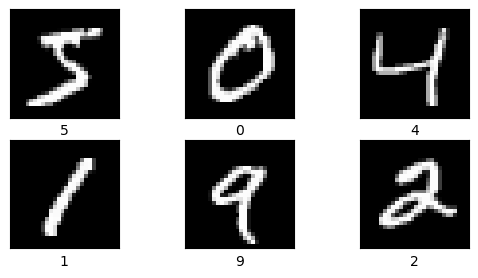

In [49]:
#Visualizo algunas imágenes de la data
for im in range(0,6):
    plt.subplot(3,3,im+1)
    plt.xlabel(y_train[im])
    plt.xticks([]),plt.yticks([]) #Con esto elimino los números que aparecen tanto en el eje 'x', como en el 'y'
    plt.imshow(x_train[im],cmap="gray")

In [51]:
#Ahora, procedo a realizar el procesamiento a las imágenes.
#Primero, transformo el shape de la data (pues la CNN debe recibir imágenes de la forma (image_height, image_width,image_channels), sin incluir el batch dim
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1) #1 representa los canales de la img (1 porque es escala de grises)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

In [55]:
#Veo el shape nuevo de la data
print(x_train.shape,x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [57]:
#Ahora, realizo la normalización de los valores imágenes (rango de 0-1 para los valores de los píxeles) para hacer más eficiente el proceso
x_train=x_train.astype("float32")/255
x_test=x_test.astype("float32")/255

In [83]:
#Ya que procesé la data, ahora procedo a crear la arquitectura de la CNN
from tensorflow import keras
from tensorflow.keras import layers
inputs=keras.Input(shape=(28,28,1)) #Acá establezco el shape de los datos que la red recibirá (como son imágenes a EG --> img_channels=1)
x=layers.Conv2D(filters=32,kernel_size=3,activation="relu")(inputs) #Acá creo una capa de conv. con 32 filtros y un kernel de 3x3. Act. funct. --> relu
x=layers.MaxPooling2D(pool_size=2)(x) #El pool_size será de 2, de tal forma que un grid de 2 x 2, se extraiga el valor numérico más alto; es decir, capturando el valor más 'relevante' (y así reducir el tamaño de la dim de la img)
x=layers.Conv2D(filters=64,kernel_size=3,activation="relu")(x) #Lo mismo, kernel de 3x3, pero 64 filtros ahora
x=layers.MaxPooling2D(pool_size=2)(x)
x=layers.Conv2D(filters=128,kernel_size=3,activation="relu")(x)
x=layers.Flatten()(x) #Ahora, esta capa de encargará de "aplanar" las matrices a vectores, de tal forma que pueda usarse el MLP (pues este recibe vectores)
outputs=layers.Dense(10,activation="softmax")(x) #Es decir, la capa de salida tendrá 10 neuronas (porque es la cant. de clases que la red deberá aprender a diferenciar). Softmax funct porque es clas. multiclase
modelo=keras.Model(inputs=inputs,outputs=outputs) #Acá es donde crea el modelo

In [73]:
#Ahora, veo un summary de la arquitectura de la red
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
#Ya que el modelo fue creado, separo algunas imágenes del set de train para validación y ver el performance del modelo mientras este se está entrenando
x_val,x_train_n=x_train[0:10000],x_train[10000:]
y_val,y_train_n=y_train[0:10000],y_train[10000:]
print(x_val.shape,x_train_n.shape)
print(y_val.shape,y_train_n.shape)

(10000, 28, 28, 1) (50000, 28, 28, 1)
(10000,) (50000,)


In [95]:
#Ahora, realizo el entrenamiento de la red, pero antes especifico la func. de pérdida, optim, y la métrica a usar
modelo.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy", #Uso sparse_categorical_crossentropy porque las etiquetas son números enteros, no vectores OH
    metrics=["accuracy"] #Pues quiero ver la probabilidad de que sea de una clase u otra
)

In [97]:
#Entreno al modelo
history=modelo.fit(
    x_train_n, #Especifico la data que se usará para entrenar
    y_train_n, #Especifo los labels de la data a entrenar
    validation_data=(x_val,y_val), #La data de validación para ver el performance del modelo mientras se entrena
    epochs=5, #El número de épocas
    batch_size=64 #El tamaño del lote por entrenamiento
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.8666 - loss: 0.4414 - val_accuracy: 0.9777 - val_loss: 0.0765
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9820 - loss: 0.0574 - val_accuracy: 0.9822 - val_loss: 0.0622
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9886 - loss: 0.0360 - val_accuracy: 0.9860 - val_loss: 0.0473
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9906 - loss: 0.0282 - val_accuracy: 0.9888 - val_loss: 0.0378
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9933 - loss: 0.0206 - val_accuracy: 0.9888 - val_loss: 0.0364


In [101]:
#Obtengo los valores que muestran el performance durante el entrenamiento para ver el rendimiento
accuracy=history.history["accuracy"]
loss=history.history["loss"]
val_accuracy=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

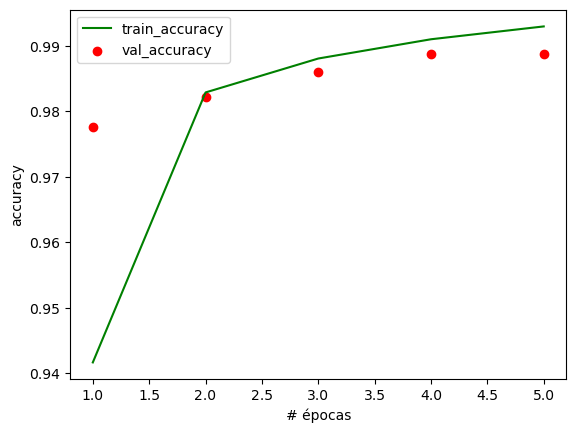

In [129]:
#Accuracy
plt.plot(range(1,len(accuracy)+1),accuracy,color="green",label="train_accuracy")
plt.scatter(range(1,len(accuracy)+1),val_accuracy,color="red",label="val_accuracy")
plt.xlabel("# épocas")
plt.ylabel("accuracy")
plt.legend()
plt.show()

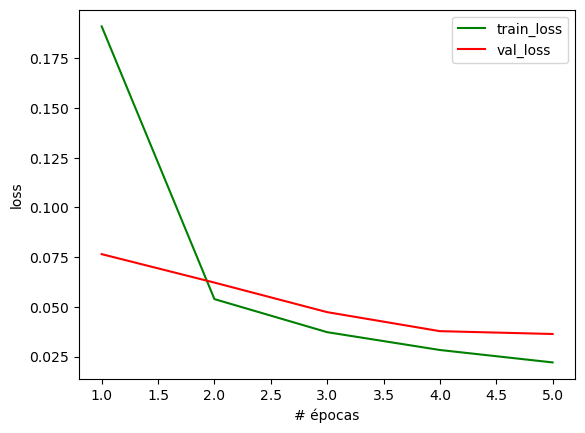

In [131]:
#Loss
plt.plot(range(1,len(loss)+1),loss,color="green",label="train_loss")
plt.plot(range(1,len(val_loss)+1),val_loss,color="red",label="val_loss")
plt.xlabel("# épocas")
plt.ylabel("loss")
plt.legend()
plt.show()

In [133]:
#Realizo algunas predicciones para ver el performance del modelo
val_pred=modelo.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


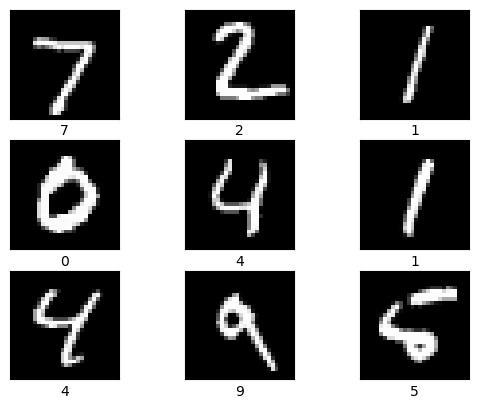

In [203]:
#Ahora, realizo un plotteo de algunos imágenes con los valores predichos para ver el performance
for im_p in range(0,9):
    plt.subplot(3,3,im_p+1) 
    plt.xticks([]),plt.yticks([])
    plt.xlabel(np.argmax(val_pred[im_p])) #Acá obtengo el índice de mayor valor, donde el índice coincide con la clase de la imagen
    plt.imshow(x_test[im_p],cmap="gray")